In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

set_matplotlib_formats('retina')

# data on papers with fewer than 200 citations
data = pd.read_csv('./data/articles_features.csv')[['AvgAuthorRank', 
                                                  'AvgAffiliationRank', 
                                                  'JournalRank', 
                                                  'CitationCount']].query('CitationCount<=200')
data['HighlyCited'] = (data['CitationCount'] > 50).astype('int')

from IPython.display import set_matplotlib_formats

X = data[['AvgAuthorRank', 'AvgAffiliationRank', 'JournalRank']].values
y = data.CitationCount.astype('float')
kf = KFold(n_splits=5)

def generate_predictions(data, model):
    predictions = []    
    for gidx, g in data.groupby(['c1', 'c2']):
        model.fit(g['x'].values.reshape(-1,1), g['y'])
        pred_x = np.linspace(g['x'].min(), g['x'].max()).reshape(-1,1)
        pred_y = model.predict(pred_x)
        predictions.append(pd.DataFrame({'c1': g['c1'].values[0], 
                                         'c2': g['c2'].values[0], 
                                         'x_pred': pred_x[:, 0], 
                                         'y_pred': pred_y}))
    return pd.concat(predictions)

<ipython-input-19-229d0b06d9f9>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Science of Science Summer School (S4) 2021
## Day 2: AI/ML
### Generalization performance: regression and classification
- Daniel E. Acuna, School of Information, Syracuse University
> Execute `02-05-notebook-model_evaluation.ipynb`  along

# From previous unit
- We took a **statistical approach to learning** which acknowledges our uncertainty and noise in the data science process.  

- We defined a **model** of the data.  

- We estimated the parameters using **training data**.  

- We used the model to **predict** and **interpret** the results.  

- We could use **supervised** or **unsupervised** learning to find relationships between variables.  

- If variables are not quantitative, we used classification models.

# In this unit
- Generalization performance
- Estimating generalization performance: cross-validation
- Bias-variance decomposition
- Performance of classifiers: confusion matrix, ROC curve, AUC
- Bayes rule

<center><img src="./images/unit-06/unit-06-0_ama1.png" width="800" align="center"></center>

<center><img src="./images/unit-06/unit-06-0_ama2.png" width="800" align="center"></center>

# Generalization performance
- Generalization is the performance of a learning method on independent **test data**.  

- Generalization performance guides the choice of learning method or model.  
- **Why don't we teach the *best method*?**
  - *Because there is no free lunch in statistics*: David Wolpert, "The Lack of A Priori Distinctions Between Learning Algorithms", 1996.
  <div class="blockquote2">
    No one method dominates all others over all possible data sets.
  </div>

# Generalization performance (2)
- The no free lunch theorem implies that we need to:  

  1. Learn about the **particular dataset** we are working on (data science!)  
  
  2. **Select the best method** using generalization performance (data science!)


# Measuring generalization performance: theory
- We need to define a loss function:

$$l(Y,\hat{f}(X))$$  

- For example, the Squared Error for regression:

$$l(Y,\hat{f}(X)) = (Y - \hat{f}(X))^2$$  

<center>(which is the same as the negative likelihood with Gaussian noise.)</center>  

- Or zero-one loss for classification:

$$l(Y,\hat{f}(X)) = \text{I}(Y \neq \hat{f}(X))$$  

<center>where $\text{I}(a,b)$ is 1 if $a = b$, and 0 otherwise.</center>  

# Measuring generalization performance: test error and expected prediction error
- Test error is the prediction error over an *independent* test sample:

$$Err_T = E[l(Y,\hat{f}(X)) \mid T]$$  

<center>where both $Y$ and $X$ are randomly sampled with a fixed training set $T$.</center>

- A related quantity is the expected prediction error:

$$Err = E[l(Y,\hat{f}(X))] = E[Err_T]$$  

<center>where everything is random including the training dataset.</center>

- Most methods effectively estimate $Err$ instead of $Err_T$.

# Measuring generalization performance: model comparison

- Typically, we must compare several models
- We split the data into **three datasets** and compute the following over a **testing dataset**
$$Err_{V,T}=E[l(Y,\hat{f}(X))\mid V,T ]$$
where $V$ is a **validation dataset**, and $T$ is a **training dataset**. 
- We further restrict the previous quantity to the best model on **validation** performance, and therefore we end up estimating
$$Err = E[E_T[Err_{V^*,T}]]$$

# Example measure of errors in regression
- Mean squared error
$$\text{MSE}=\frac{\sum (y_i-\hat{y_i})^2}{n}$$
- Root mean squared error
$$\text{RMSE}=\sqrt{\frac{\sum (y_i-\hat{y_i})^2}{n}}$$
- Coefficient of determination
$$R^2=1-\frac{u}{v}$$
where $u=\sum (y_i - \hat{y}_i)^2$ and $v=\sum (y_i - \sum \frac{y_i}{n})^2$


# Estimating test error in practice: cross validation
<br>

<div class="container2">
  <div class="row2">
    <div class="col-6">
          <ul>
            <li>Often, models have differing degrees of complexity controlled by a parameter $\alpha$ (e.g., $\;\hat{f}_\alpha(X)$)</li>
              <li><b>Training split</b> is used to **fit** one model.</li>
              <li><b>Validation split</b> is used to select **complexity**.</li>
              <li><b>Test split</b> is used to estimate **expected test error**.</li>  
          </ul>        
    </div>
  <div class="col-6">
    <ul>
    <center><img src="./images/unit-06/unit-06-0_ama3.png" width="100%" align="center"></center>
    </ul>
</div>

# Estimating test error in practice: cross validation (2)
- The previous approach is known as **training, validation, and testing split**
- If no alternative models are compared, there are only two splits and the method is known as training and testing
- Typical data splits are 60%-30%-10% for training, validation, and testing
- Or 80%-20% for training and testing splits

# Estimating the expected test error: $k$-fold cross validation
<br>
<div class="container2">
  <div class="row2">
    <div class="col-6">
      <ul>
        <li>The problem with the previous procedure is that we "throw away" the validation and test splits during training.</li>
        <br>  
        <li>$k$-fold cross validation (partially) fixes this by running cross validation multiple times.</li>
      </ul>        
    </div>
  <div class="col-6">
    <center><img src="./images/unit-06/unit-06-0_ama4.png" width="600" align="center"></center>
</div>

# More on expected test error
- The loss function used to cross validation **does not** necessarily match the loss function used during model fitting.
- For example, you can fit models with gradient descent to minimize MSE (because it is easy and fast) but you might choose models based on the Mean Absolute Deviation (MAD)
$$\text{MAD} = \frac{1}{n} \sum_{i=1}^n | \hat{y}_i - y |$$

# The Bias-Variance decomposition: Math
- Mathematically:  

\begin{align}
Err(x_0) &= E[(Y-\hat{f}(x_0))^2\mid x_0] \\
Err(x_0) &= \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)]-f(x_0))^2 + E[\hat{f}(x_0)-E[\hat{f}(x_0)]]^2 \\
Err(x_0) &= \text{Irreducible error} + \text{Bias}^2 + \text{Variance}
\end{align}  

# The Bias-Variance decomposition of test error
- In general, more complex models have low bias and high variance.  

- Vice versa, simple models have high bias and low variance.  

- This is a **fundamental tradeoff**.  

- **High variance** means that the estimation has high "error bars."  

- **High bias** means that the estimation will not change much even if more data is seen.

In [3]:
from plotnine import *

def f(x):
    return 5*x**-2.1

def e(x):
    return np.random.randn(x.shape[0])/2

n = 500
x = np.random.random(size=n)*9+0.8
c1 = np.random.choice(range(0, 3), size=n)
c2 = np.random.choice(range(0, 3), size=n)
y = f(x) + e(x)

toy_dataset = pd.DataFrame({'x': x, 'y': y, 'c1': c1, 'c2': c2})

# The Bias-Variance decomposition: Math
$$E[(Y-\hat{f}(x_0))^2\mid x_0] =  \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)]-f(x_0))^2 + E[\hat{f}(x_0)-E[\hat{f}(x_0)]]^2$$

$$f(x) = 5x^{-2}$$
$$Y = f(x) + \epsilon$$

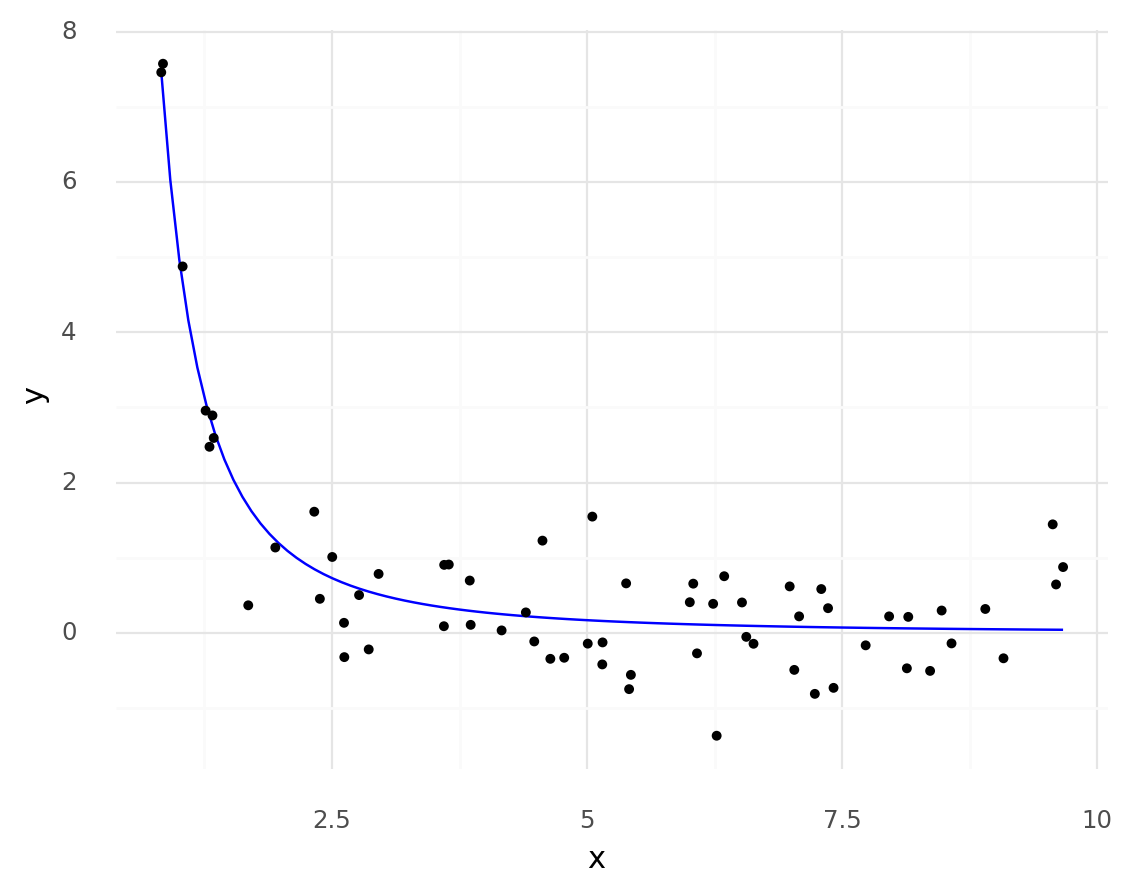

In [8]:
(ggplot(aes(x='x', y='y'), data=toy_dataset.query('c1==0 and c2==0')) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + theme_minimal()
).draw();

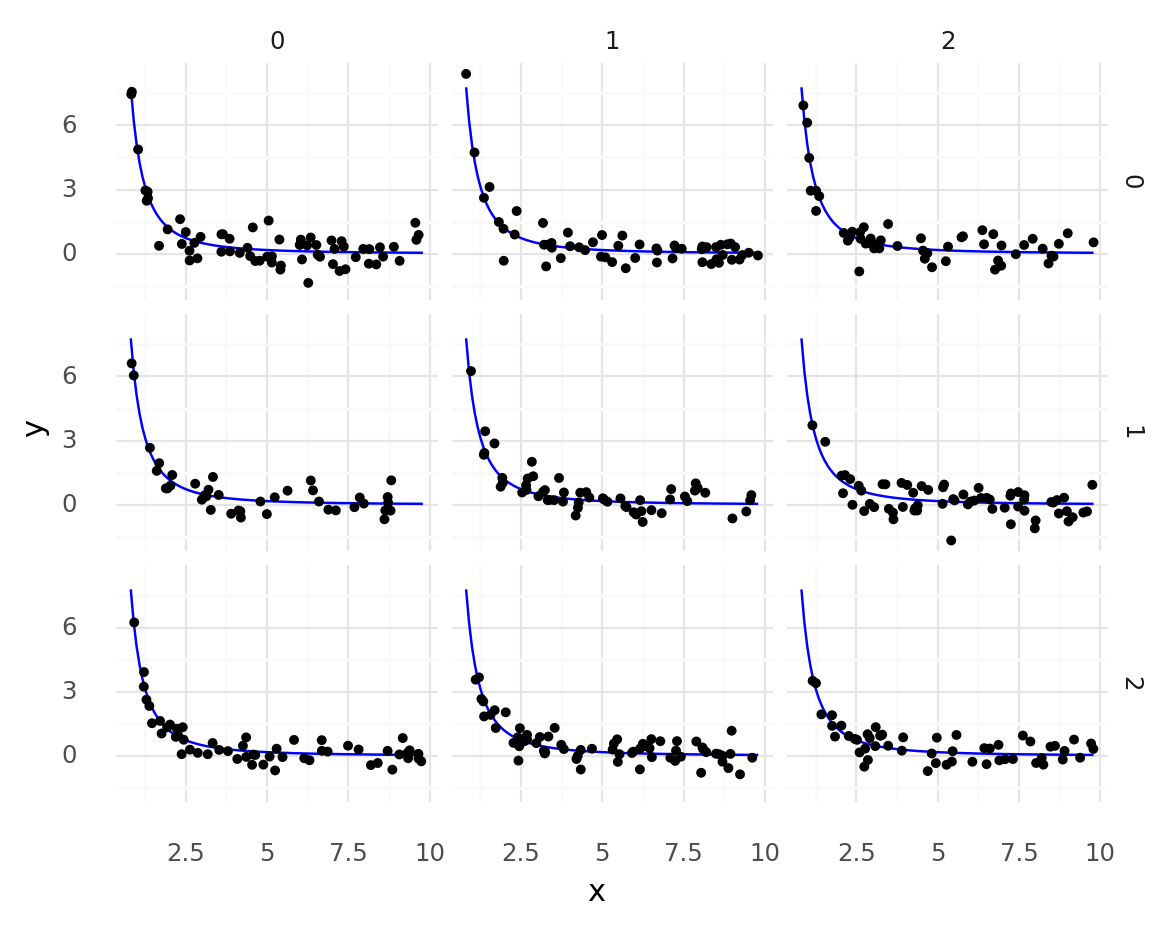

In [39]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
).draw();

# Predictions with a simple model

$$E[(Y-\hat{f}(x_0))^2\mid x_0] =  \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)]-f(x_0))^2 + E[\hat{f}(x_0)-E[\hat{f}(x_0)]]^2$$

$$f(x) = 5x^{-2}$$
$$Y = f(x) + \epsilon$$

Linear regression: $\hat{y} = b_0 + b_1 x$

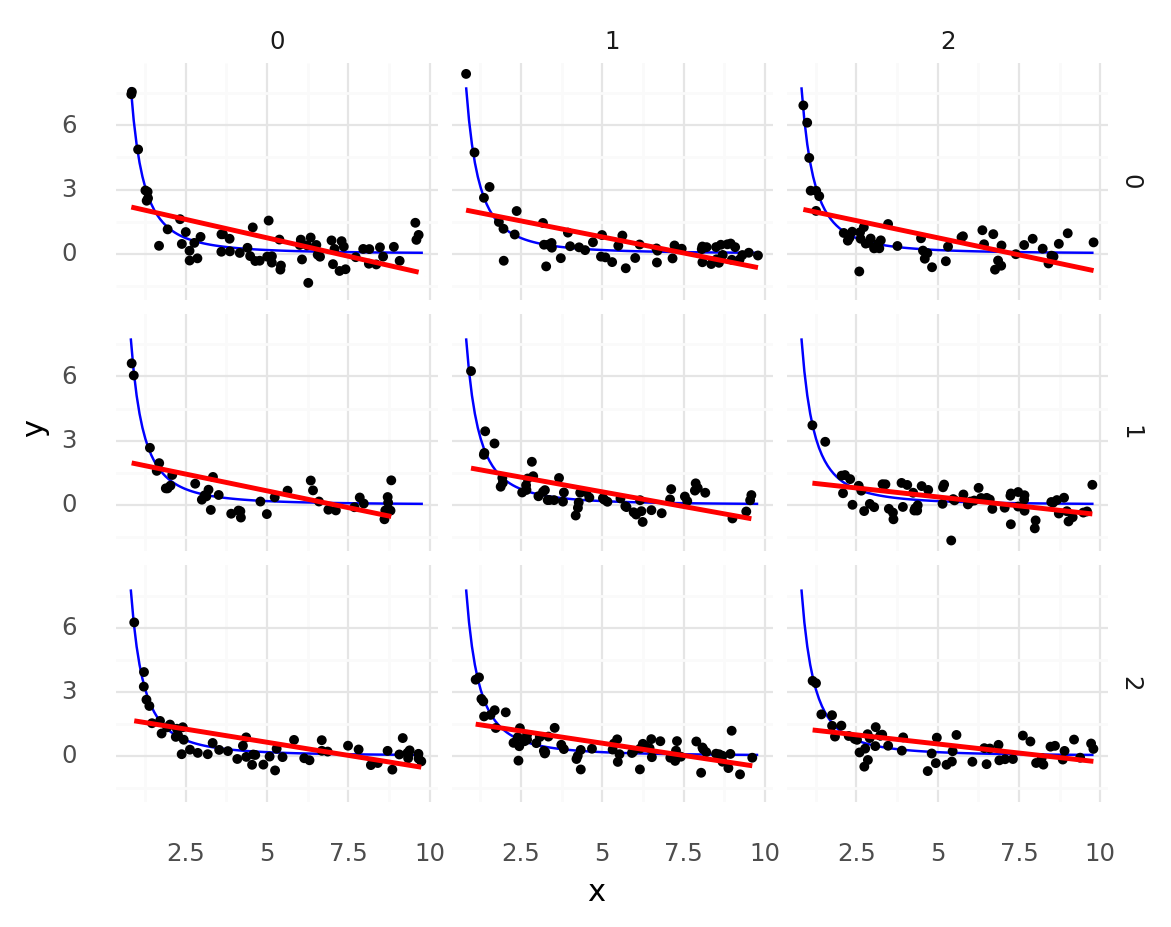

In [35]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + geom_line(aes(x='x_pred', y='y_pred'), 
             data=generate_predictions(toy_dataset, LinearRegression()), 
             size=1, 
             color='red')
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
).draw();


# Predictions with more complicated methods

$$E[(Y-\hat{f}(x_0))^2\mid x_0] =  \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)]-f(x_0))^2 + E[\hat{f}(x_0)-E[\hat{f}(x_0)]]^2$$

$$f(x) = 5x^{-2}$$
$$Y = f(x) + \epsilon$$

Nearest neighbor regression (k=1)

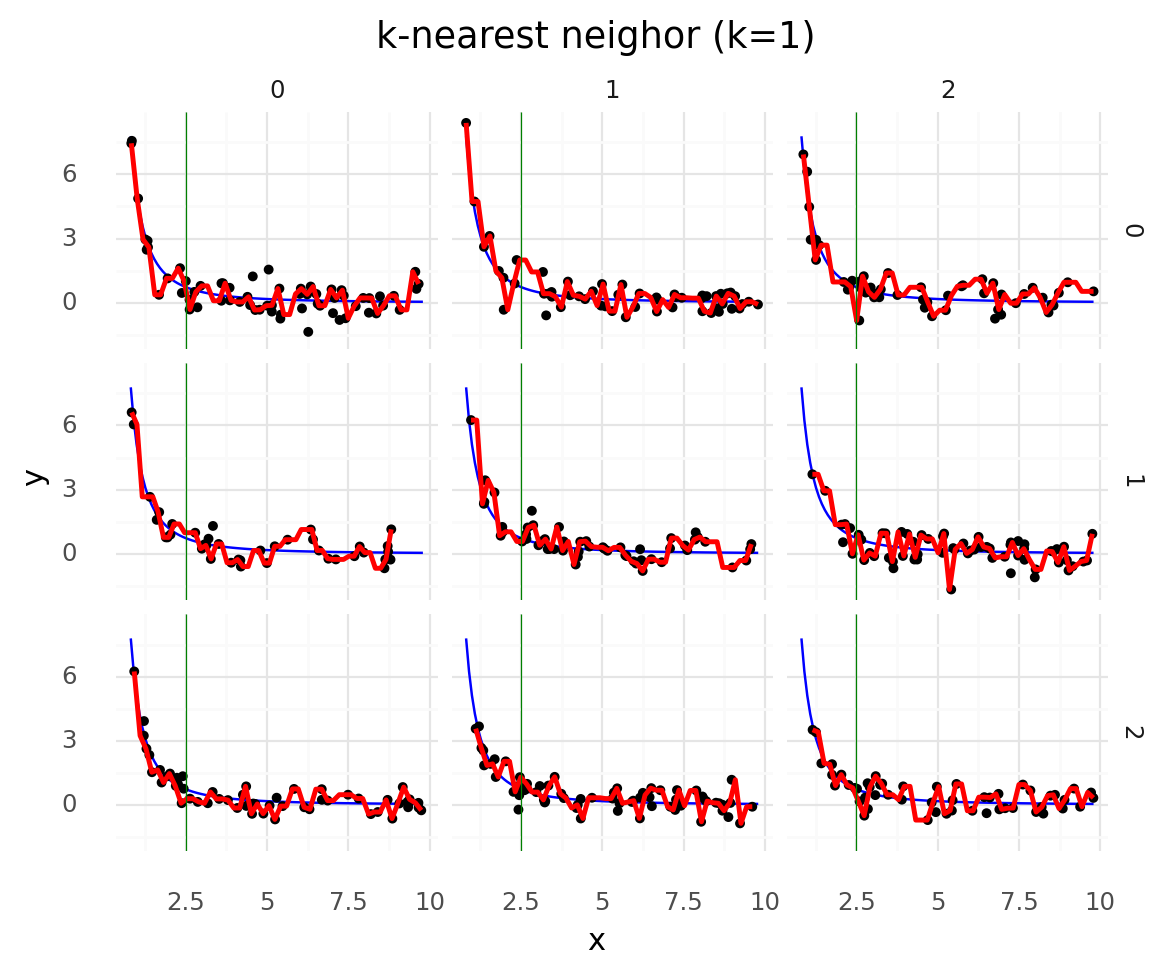

In [34]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + geom_line(aes(x='x_pred', y='y_pred'), 
             data=generate_predictions(toy_dataset, KNeighborsRegressor(n_neighbors=1)), 
             size=1, 
             color='red')
 + geom_vline(xintercept=2.5, color='green', size=0.25)
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
 + labs(title='k-nearest neighor (k=1)')
).draw();


# Predictions with more complicated methods

$$E[(Y-\hat{f}(x_0))^2\mid x_0] =  \sigma_{\epsilon}^2 + (E[\hat{f}(x_0)]-f(x_0))^2 + E[\hat{f}(x_0)-E[\hat{f}(x_0)]]^2$$

$$f(x) = 5x^{-2}$$
$$Y = f(x) + \epsilon$$

Nearest neighbor regression (k=20)

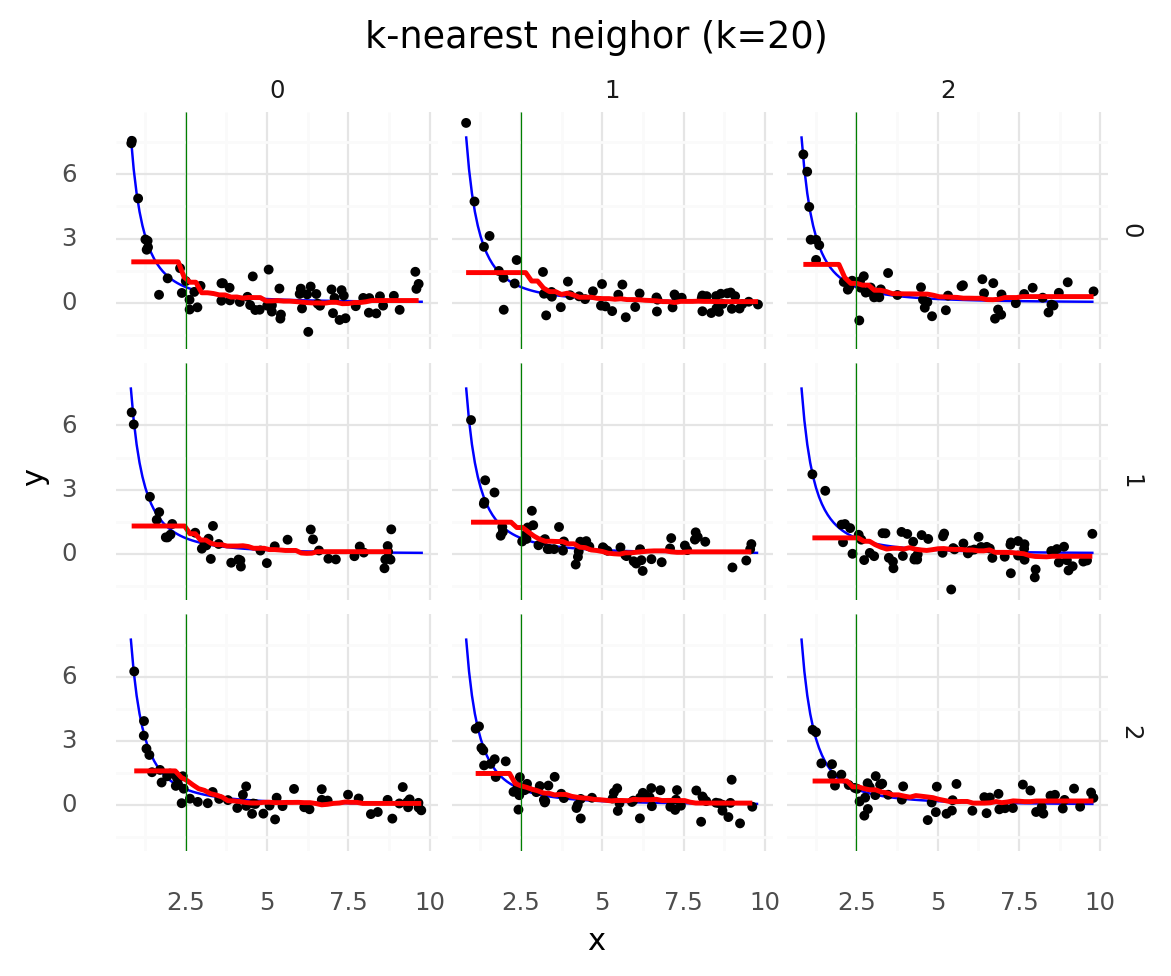

In [36]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + geom_line(aes(x='x_pred', y='y_pred'), 
             data=generate_predictions(toy_dataset, KNeighborsRegressor(n_neighbors=20)), 
             size=1, 
             color='red')
 + geom_vline(xintercept=2.5, color='green', size=0.25)
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
 + labs(title='k-nearest neighor (k=20)')
).draw();


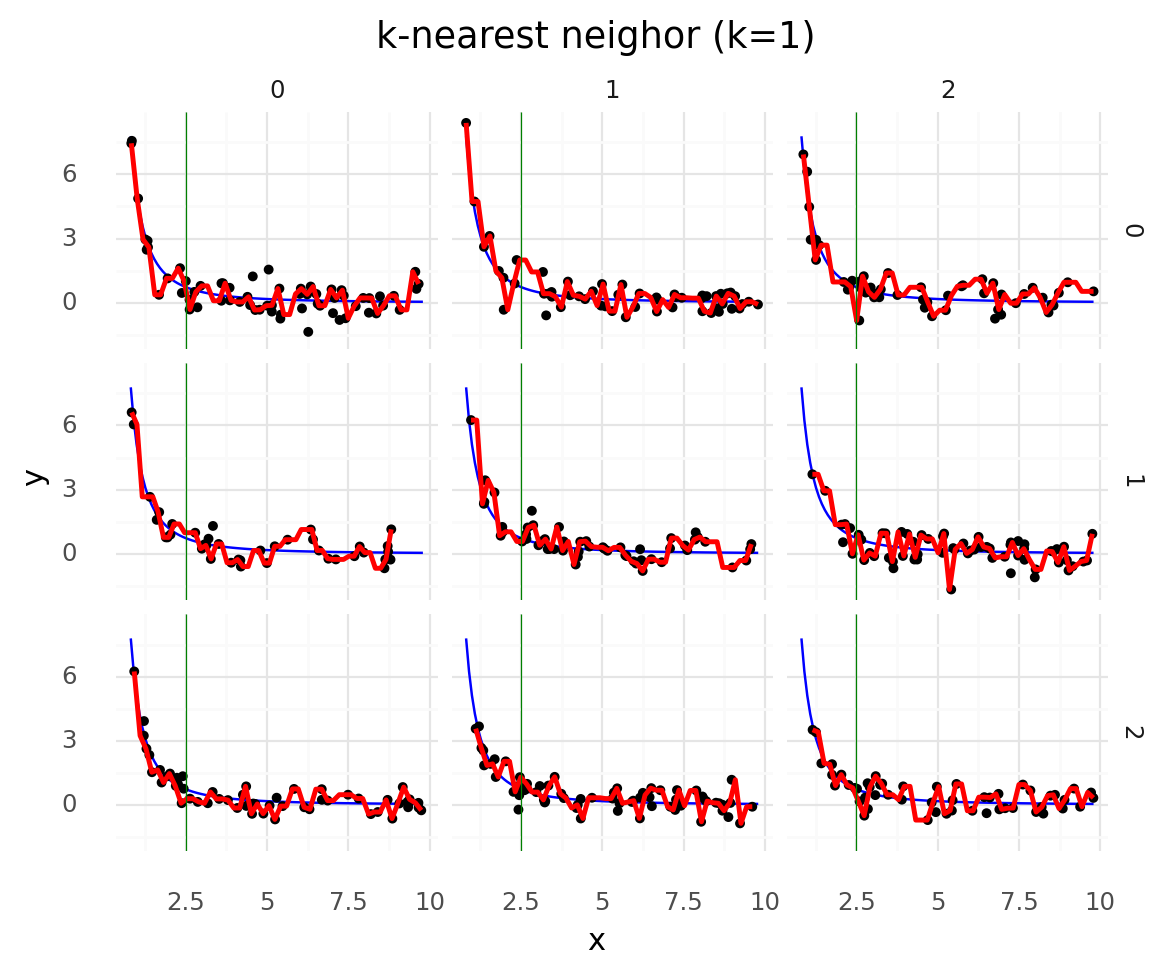

In [37]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + geom_line(aes(x='x_pred', y='y_pred'), 
             data=generate_predictions(toy_dataset, KNeighborsRegressor(n_neighbors=1)), 
             size=1, 
             color='red')
 + geom_vline(xintercept=2.5, color='green', size=0.25)
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
 + labs(title='k-nearest neighor (k=1)')
).draw();


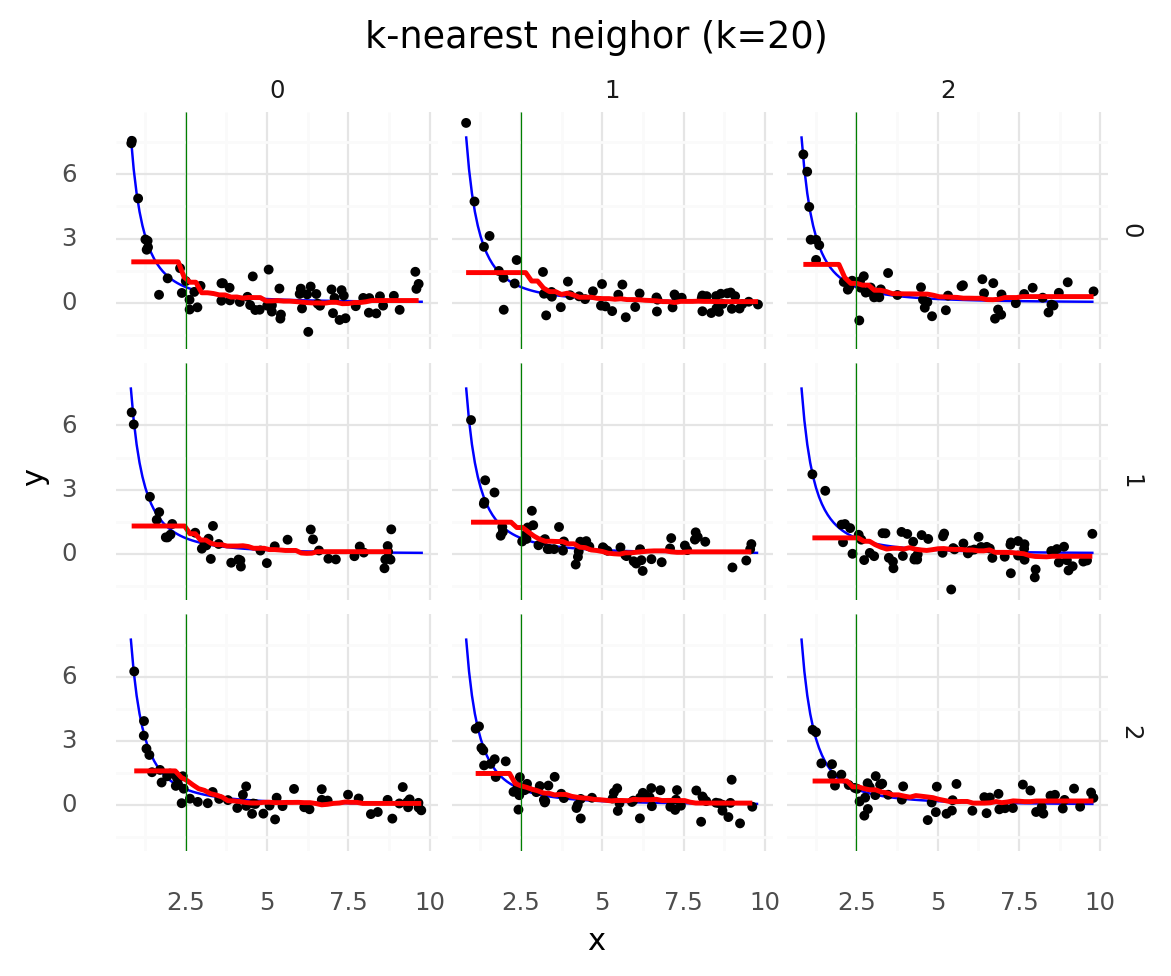

In [38]:
(ggplot(aes(x='x', y='y'), data=toy_dataset) 
 + stat_function(fun=f, color='blue')
 + geom_point(size=1) 
 + geom_line(aes(x='x_pred', y='y_pred'), 
             data=generate_predictions(toy_dataset, KNeighborsRegressor(n_neighbors=20)), 
             size=1, 
             color='red')
 + geom_vline(xintercept=2.5, color='green', size=0.25)
 + facet_grid(['c1', 'c2'])
 + theme_minimal()
 + labs(title='k-nearest neighor (k=20)')
).draw();


# The Bias-Variance decomposition: Nearest neighbor regression
- Take the $k$ closest points and compute the average $y$ of those points
$$\hat{f}(x_0) = \frac{1}{k}\sum_{i=1}^k f(x_{\text{nn}_i(x_0)})$$
where $\text{nn}_i(x)$ is the index of $i$-th closest neighbor to $x$
- The Bias-variance decomposition then becomes
$$Err(x_0) = \sigma_\epsilon^2 + [f(x_0) - \frac{1}{k}\sum_{i=1}^k f(x_{\text{nn}_i(x_0)})]^2 + \frac{\sigma_\epsilon^2}{k}$$
where $\frac{\sigma_\epsilon^2}{k}$ is the variance of $\hat{f}$
- Bias increases with $k$ and variance decreases with $k$

# The Bias-Variance decomposition: Linear regression
- The argument is more complex: $\hat{f}(x_0) = x_0^T b$ with vector $b$ having $p$ components
- On average
$$Err(x_0) \approx \sigma_\epsilon^2 + \text{Bias}^2 + p \sigma_\epsilon^2$$
- Variance is proportional to the number of parameters and therefore Bias decreases with number of parameters

# The Bias-Variance decomposition: in practice
- It is many times impossible to know the irreducible error, bias, and variance decomposition
- There are several heuristics for trying to understand whether we need to increase the bias or the variance, or whether we have simply hit the irreducible error
- We will want to **search over many models to find the one which minimizes bias and variance**

# The Bias-Variance tradeoff

Polynomial regression example: predicting article citations given author, institution, and journal rankings

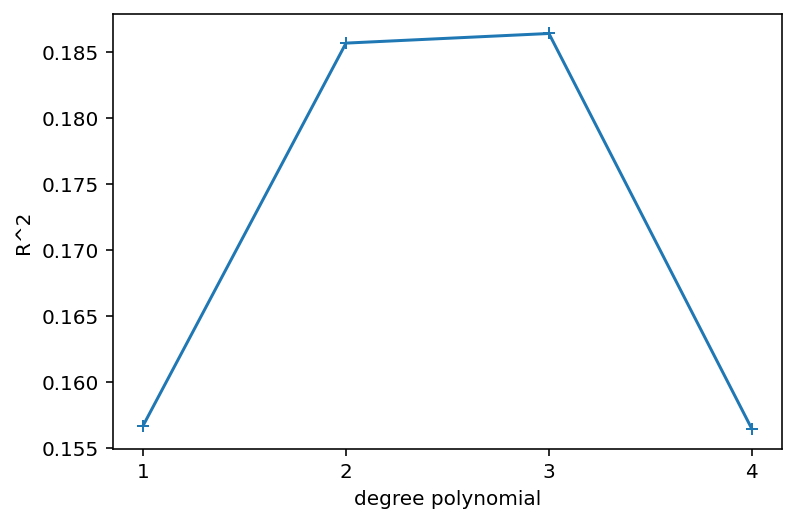

In [13]:
performance_np = np.array([[d, cross_val_score(LinearRegression(), 
                PolynomialFeatures(degree=d).fit_transform(X[:1000]), 
                y[:1000], cv=kf, n_jobs=-1).mean()] for d in range(1, 5)])
plt.plot(performance_np[:, 0], performance_np[:, 1], '+-');
plt.xlabel('degree polynomial');
plt.ylabel('R^2');
plt.xticks(range(1, 5));

# A model with high variance: random forest

- Random forest is a relatively simple idea where we use "the wisdom of the crowds" to average the prediction of several estimators
- For this, we several a "decision trees" based on uncorrelated samples of the data
- The deeper the tree, the higher the variance (the more complex the function)
- The more trees, the higher the variance (kind of)

# The Bias-Variance decomposition: the learning curve

- Predicting article citations given author, institution, and journal rankings
 - Linear regression
 - Polynomial regression
 - Random forest

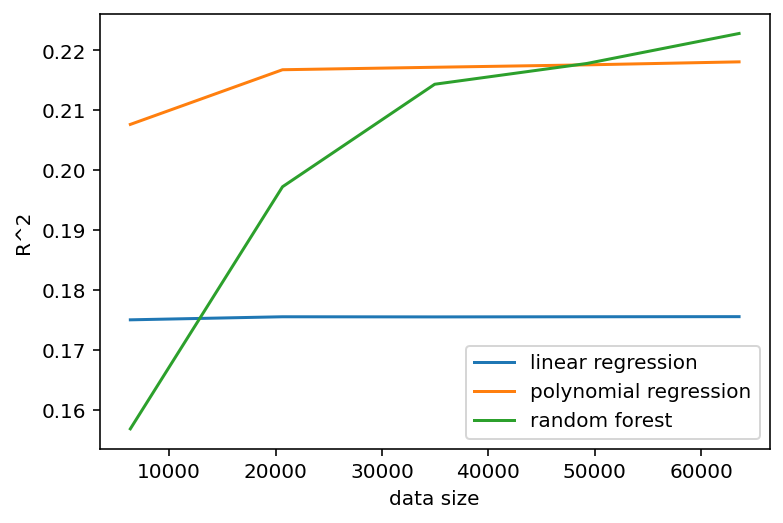

In [3]:
train_sizes_simple, train_scores_simple, test_scores_simple = \
    learning_curve(LinearRegression(), X, y, cv=kf)
train_sizes_complex, train_scores_complex, test_scores_complex = \
    learning_curve(LinearRegression(), PolynomialFeatures(degree=5).fit_transform(X), y, cv=kf, n_jobs=-1)
train_sizes_complex_rf, train_scores_complex_rf, test_scores_complex_rf = \
    learning_curve(RandomForestRegressor(), X, y, cv=kf, n_jobs=-1)

plt.plot(train_sizes_simple, test_scores_simple.mean(axis=1))
plt.plot(train_sizes_complex, test_scores_complex.mean(axis=1))
plt.plot(train_sizes_complex_rf, test_scores_complex_rf.mean(axis=1))
plt.legend(['linear regression', 'polynomial regression', 'random forest'])
plt.xlabel('data size')
plt.ylabel('R^2');

# Evaluating classification

Many tasks in science of science are about classification. For example, predict whether a paper will be highly cited or whether a sentence needs a citation

# Measuring generalization performance: classification
- A typical method for measuring classification performance is *accuracy*:  

    $$\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \text{I}(y_i,\hat{f}(x_i))$$
<center>where $\text{I}(a, b)$ is 1 if $a = b$, and 0 otherwise.</center>  


- What might be the problem with using accuracy? (hint: What is the accuracy of an algorithm that predicts that every email received is not a spam?)

# Measuring generalization performance: confusion matrix
- This matrix is called a **confusion matrix**: summary of true vs predicted cases
<center><img src="./images/unit-06/unit-06-0_ama9.png" width="80%" align="center"></center>

# Measuring generalization performance: Common statistics from confusion matrix
- **Prevalence**: (TP+FN) / everything
- **Precision**: TP / (TP + FP)
- **Sensitivity**, **Recall**, or **True positive rate**: TP / true condition positive
- **Specificity**: TN / true condition negative
- **F1**: $\frac{2*precision*recall}{precision + recall}$

# Measuring generalization performance: ROC curve
- In general, no single algorithm has the best sensitivity and specificity simultaneously.
- Some algorithms offer a range of sensitivity/specificity points.  ROC curve displays this

<center><img src="./images/unit-06/unit-06-0_ama10.png" width="100%" align="center"></center>

# Measuring generalization performance: ROC curve (2)
- We will classify as spam if classifier thinks with more than 50% probability.  

<br>
<center><img src="./images/unit-06/unit-06-0_ama11.png" width="100%" align="center"></center>

# Measuring generalization performance: ROC curve (3)
- **Less stringent, we will classify as spam if P(spam) > 0.1**

<br>
<center><img src="./images/unit-06/unit-06-0_ama12.png" width="100%" align="center"></center>

# Measuring generalization performance: ROC curve (4)
- We can put the two thresholds $\theta = 0.5$ and $\theta = 0.1$ in a plot.

<br>
<center><img src="./images/unit-06/unit-06-0_ama13.png" width="50%" align="center"></center>

# Measuring generalization performance: ROC curve  (5)
- We can do this for every threshold value and plot the result as a curve.  
<br>
<center><img src="./images/unit-06/unit-06-0_ama14.png" width="50%" align="center"></center>
<br>
<u>**Activity**</u>: can you guess the curve of a random classifier?

# Measuring generalization performance: ROC curve (6)
- We can do this for every threshold value and plot the result as follows:  

<br>
<div class="container2">
  <div class="row2">
    <div class="col-8">
      <center><img src="./images/unit-06/unit-06-0_ama15_2.png" width="50%" align="center"></center>
    </div>
  <div class="col-4">
    <br>  
    <p>A measure that combines all thresholds is the **Area Under the ROC Curve (AUC)**</p>
</div>     

# Area under the ROC curve (AUC)

- It is hard to interpret but:
    - It can be thought as how good is the model to rank the probabilities with the real labels
- The **AUC** is 1/2 if the classifier is *random* or *constant*
- **Activity: show that the AUC is in fact 1/2 for a random predictor**

# AUC for random prediction

- AP, AN, PP, PN mean actual positive, actual negative, predicted positive, and predictived negative, respectively
- There are $n$ cases in total

| .  | PP|PN |
|---|---|---|
| AP| TP|FN |
| AN| FP|TN |

- Cases are gonna randomly fall on PP and PN. 
- For a given threshold $\theta$, FP = $(1-\theta)$AN and TN=$\theta$AN, and similarly TP=$(1-\theta)$AP and FN=$\theta$AP
- FPR = $(1-\theta)$AN/($(1-\theta)$AN + $\theta$AN) = $1-\theta$
- Therefore, AUC = $\frac{1}{2}$

# AUC for constant prediction
- As we move the threshold there will be a change between all points being in PP to PN, or viceverse.
- There two points will have FPR=TPR=0 and FPR=TPR=1 respectively
- By interpolation, AUC = $\frac{1}{2}$

# Take home message
- Always keep the testing dataset in vault until the end of your analysis.  

- Use model selection to choose from models of different complexity.  

- Stick to a loss function throughout your analysis.  

- For classification problems, think carefully about the requirements of your problem.  

- Be careful about the prevalence values.